In [1]:
# utilize the lorenz equations to construct
# multiple noisy conditions leading to single and multipeak distributions in the next time step

import numpy as np
from scipy.integrate import odeint
import os,sys
import sklearn.preprocessing
# save the default color cycle for plotting
import matplotlib.pyplot as plt
import pickle
full_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
cycle      = full_cycle[2:]

# figure_path = '../reports/figures'
# data_path = '../data/artificial'

In [2]:
# lorenz system parameters
# only certain choices lead to chaotic behaviour
rho = 45.92
sigma = 16.0
beta = 8.0 / 2.0

# lorenz equations
# coupled differential system
def lorenz_equation(state, t):
    x, y, z = state  # unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

In [3]:
# solve the lorenz eq. for givin initial values and time stemps
def lorenz(t, init):
    return odeint(lorenz_equation, init, t)

In [4]:
# generate the data from the solution of the lorenz system
def generate_data(t,samples=1,mixtures=[],inits=[],noise=0.6):
    
    # param samples  :  how many samples to generate
    # param mixtures :  list of floats between zero and one. gives the interval for the random selection
    #                   so [0.1 , 0.8, 1.0] will lead to a mixture of 10%, 60% and 20%
    # param inits    :  initial y_0 values for lorenz system, list of length mixtures
    # noise          :  gaussian noise added to each data sample  
    
    # for each lorenz init we need exactly one mixture, e.g y_0 = 1.001 in 20% of the cases
    assert(len(mixtures)==len(inits))
    
    # these are the bare candidates for the sample
    # without noise
    candidates = []
    data = np.zeros((samples,t.shape[0],1))
    candidate_index = np.zeros((samples),dtype=int)
    #print(data.shape,candidate_index.shape)
    
    for init in inits:
        candidates.append( lorenz( t, init)[:,0:1].tolist() )
    candidates =  np.array(candidates)
    #print(candidates.shape)
    
    # now we generate the actual sample
    randoms = np.random.uniform(size=samples)
    #for each mixture and lorenz candidate
    for i in range(len(mixtures)):
        # compute random indices where the fraction is exactly the given mixture
        if i==0:
            indices = np.where( (randoms>=0) & (randoms<mixtures[i]) )[0]
        else:
            indices = np.where( (randoms>=mixtures[i-1]) & (randoms<mixtures[i]) )[0] 
        # put the candidate at these indices and add gaussian noise
        for index in indices:
            data[index] = candidates[i] + np.random.normal( loc=0.0, scale=noise, size=candidates[i].shape )
            candidate_index[index] = i
    
    # return the sample and the candidate index to now which sample belongs to which y_0
    return data,candidate_index,t

In [5]:
# how to rebin 3d array 
def rebin(arr, new_shape):
    
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1],)
    return arr.reshape(shape).mean(-1).mean(1)

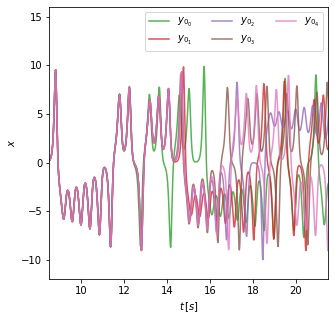

In [6]:
# plot the system once

t = np.arange(0.0, 26.0, 0.02)

inits = [ 
    [ 1.0, 1.0001         , 1.0 ],
    [ 1.0, 1.000001       , 1.0 ],
    [ 1.0, 1.00000001     , 1.0 ],
    [ 1.0, 1.0000000001   , 1.0 ],
    [ 1.0, 1.000000000001 , 1.0 ],
]

plt.figure(figsize=(5,5))
for i,init in enumerate(inits):
    plt.plot( t, lorenz(t, init)[:,0:1]/3.0, color=cycle[i], alpha=0.8,label=r'$y_{0_{%i}}$' % i )
plt.legend(ncol=3)
plt.ylim((-12,16))
plt.xlim((8.5,21.5))
plt.ylabel(r'$x$')
plt.xlabel(r'$t\,[s]$')
plt.show()    

In [7]:
# generate a gausian mixture
num_candidates = 5
points = 1000
distr = np.clip( np.random.normal( loc=0.5, scale=0.2, size=points), a_min=0, a_max=1 )

mixtures, edges = np.histogram(distr,bins=num_candidates)
mixtures = mixtures/points
tmp = 0
for i,mixture in enumerate(mixtures):
    tmp += mixture
    mixtures[i] = tmp    

# with five candidates

In [8]:
# generate the data sample
data,indices,t = generate_data(t,samples=100000,mixtures=mixtures,inits=inits,noise=7.2)
print(data.shape)
unique, counts = np.unique(indices, return_counts=True)
print(unique,counts/100000)

(100000, 1300, 1)
[0 1 2 3 4] [0.07901 0.23725 0.38411 0.24515 0.05448]


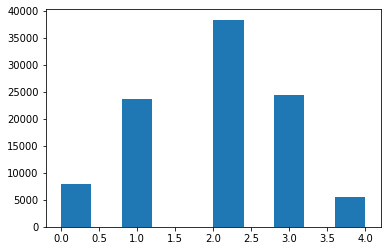

In [9]:
# five different candidates with gaussian distribution
plt.figure()
plt.hist(indices)
plt.show()

In [10]:
# rebin and scale the data

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-10,10))

print(data.shape)
rebinned_data = rebin(data[:,:,0],(data.shape[0],data.shape[1]//10))
print(rebinned_data.shape)
rebinned_time = t[::10]

scaler.fit(rebinned_data)
rebinned_data = scaler.transform(rebinned_data)
rebinned_data = rebinned_data.reshape((rebinned_data.shape[0],rebinned_data.shape[1],1))
print(rebinned_data.shape)

(100000, 1300, 1)
(100000, 130)
(100000, 130, 1)


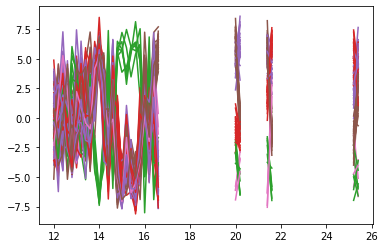

In [11]:
# zoom in for selection process
fig = plt.figure()
for i in range(rebinned_data[:100].shape[0]):
    # this may be used as condition
    plt.plot(rebinned_time[60:84],rebinned_data[i][60:84],color=cycle[indices[i]])
    # this may be used as next time step
    plt.plot(rebinned_time[100:102],rebinned_data[i][100:102],color=cycle[indices[i]])
    plt.plot(rebinned_time[107:109],rebinned_data[i][107:109],color=cycle[indices[i]])
    plt.plot(rebinned_time[126:128],rebinned_data[i][126:128],color=cycle[indices[i]])
plt.show()

In [12]:
# extract conditions and target values (next time steps)
conditions = rebinned_data[:,60:84]
y = np.zeros((conditions.shape[0]))
for i in range(rebinned_data.shape[0]):
    random = np.random.uniform()
    # use random choice to have next time step independent of condition noise
    if random>0.4:
        y[i] = np.random.choice(rebinned_data[i][100:101][0])
    elif random>0.7:
        y[i] = np.random.choice(rebinned_data[i][107:109][0])
    else:
        y[i] = np.random.choice(rebinned_data[i][126:128][0])

In [13]:
# resort in different classes where conditions and y are grouped
y_classes = {}
X_classes = {}
for i in np.unique(indices):
    class_indices = np.where( indices == i)[0]
    y_classes['class %i' % i] = y[class_indices]
    X_classes['class %i' % i] = conditions[class_indices]

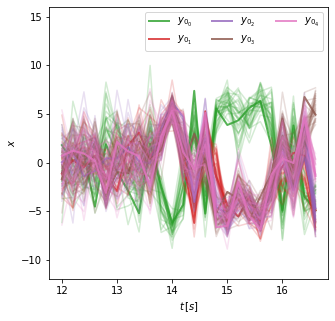

In [14]:
# plot conditions
plt.figure(figsize=(5,5))
for i,xc in enumerate(X_classes.values()):
    for j,condition in enumerate(xc[:30]):
        if j==0 :
            plt.plot(rebinned_time[60:84],condition,color=cycle[i],alpha=0.8,linewidth=2,label=r'$y_{0_{%i}}$' % i)
        else:
            plt.plot(rebinned_time[60:84],condition,color=cycle[i],alpha=0.2)
plt.legend(ncol=3)
#plt.title('Lorenz system around bifurcation region')
plt.ylim((-12,16))
#plt.xlim((-1,25))
plt.ylabel(r'$x$')
plt.xlabel(r'$t\,[s]$')
plt.show()

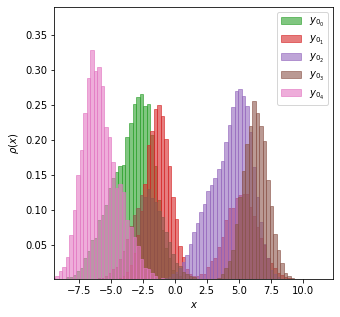

In [15]:
# plot distr of next time steps
plt.figure(figsize=(5,5))
for i,yc in enumerate(y_classes.values()):
        plt.hist(yc,range=(-11,11),bins=80,color=cycle[i],edgecolor=cycle[i],density=True,alpha=0.6,label=r'$y_{0_{%i}}$' % i)
plt.legend()

plt.ylim((0.001,0.39))
plt.xlim((-9.4,12.4))
plt.ylabel(r'$\rho(x)$')
plt.xlabel(r'$x$')
plt.show()

In [16]:
train_bounderies = [0]
val_bounderies = [0]
test_bounderies = [0]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

first = True

for x,y in zip(X_classes.values(),y_classes.values()):
    train_border = int(x.shape[0]*0.5)
    valid_border = int(x.shape[0]*0.6)
    if first:
        first = False
        x_train = x[:train_border].tolist()
        x_val = x[train_border:valid_border].tolist()
        x_test = x[valid_border:].tolist()
        
        y_train = y[:train_border].tolist()
        y_val = y[train_border:valid_border].tolist()
        y_test = y[valid_border:].tolist()
    else:
        x_train.extend(x[:train_border].tolist())
        x_val.extend(x[train_border:valid_border].tolist())
        x_test.extend(x[valid_border:].tolist())
        
        y_train.extend(y[:train_border].tolist())
        y_val.extend(y[train_border:valid_border].tolist())
        y_test.extend(y[valid_border:].tolist())
    train_bounderies.append(len(x_train))
    val_bounderies.append(len(x_val))
    test_bounderies.append(len(x_test))

x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.reshape(x_train,[x_train.shape[0],x_train.shape[1]])
y_train = np.reshape(y_train,[y_train.shape[0],1])

x_val = np.reshape(x_val,[x_val.shape[0],x_val.shape[1]])
y_val = np.reshape(y_val,[y_val.shape[0],1])

x_test = np.reshape(x_test,[x_test.shape[0],x_test.shape[1]])
y_test = np.reshape(y_test,[y_test.shape[0],1])

In [17]:
dataset_reformed = {"x_train":{},
                    "x_val":{},
                    "x_test":{},
                    "y_train":{},
                    "y_val":{},
                    "y_test":{}}

In [18]:
for i in range(len(train_bounderies)-1):
    dataset_reformed['x_train']['condition_{}'.format(i)] = x_train[train_bounderies[i]:train_bounderies[i+1]]
    dataset_reformed['y_train']['condition_{}'.format(i)] = y_train[train_bounderies[i]:train_bounderies[i+1]]

In [19]:
for i in range(len(val_bounderies)-1):
    dataset_reformed['x_val']['condition_{}'.format(i)] = x_val[val_bounderies[i]:val_bounderies[i+1]]
    dataset_reformed['y_val']['condition_{}'.format(i)] = y_val[val_bounderies[i]:val_bounderies[i+1]]

In [20]:
for i in range(len(test_bounderies)-1):
    dataset_reformed['x_test']['condition_{}'.format(i)] = x_test[test_bounderies[i]:test_bounderies[i+1]]
    dataset_reformed['y_test']['condition_{}'.format(i)] = y_test[test_bounderies[i]:test_bounderies[i+1]]

In [21]:
with open("./lorenz_dataset.pickle","wb") as outfile:
    pickle.dump(dataset_reformed,outfile)